In [73]:
import ast
import json
import os
from mailcap import subst

from hexbytes import HexBytes

import dask.dataframe as dd
import networkit as nk
import networkx as nx
from web3 import Web3

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()


True

In [2]:
ALCHEMY_API_URL = os.getenv("ALCHEMY_API_URL")
web3 = Web3(Web3.HTTPProvider(ALCHEMY_API_URL))

In [36]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,        # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [37]:
dd_arbs = dd.read_csv(config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_logs.csv",
                      dtype={'end_amount': 'object',
                             'error': 'object',
                             'profit_amount': 'object',
                             'start_amount': 'object',
                             },
                      converters={'logs': parse_logs}
                      )

In [38]:
dd_arbs["logs"] = dd_arbs["logs"].apply(parse_logs, meta=("logs", "object"))

In [18]:
dd_normal = dd.read_csv(config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_logs.csv")
dd_normal["receipt"] = dd_normal["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_normal["logs"] = dd_normal["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [29]:
dd_arbs.head()

,id,created_at,account_address,profit_token_address,block_number,transaction_hash,start_amount,end_amount,profit_amount,error,protocols,logs
0,7108fc71-883d-45b2-a6d4-0da61eb0a777,2023-05-18 15:32:43.208654,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950601,0x7836e253e6b932564e23e3162badd365ff8fbfa93f9f...,54865003552880478,62515568704076031,7650565151195553,<NA>,"[""uniswap_v2""]",[{'blockHash': '0x196c250ac3f953b996f9024ec93c...
1,23cd0052-4fb9-4ded-a6ff-5c2c7998f24d,2023-05-18 15:32:45.587223,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950602,0x299048408548ccd465e99a83d7342467a65a780064f4...,89185111706660168,92271485564350625,3086373857690457,<NA>,"[""uniswap_v2"",""uniswap_v3""]",[{'blockHash': '0xb7b27a4871eba9cd96bf6b2704b2...
2,a37c326f-9630-4034-ba32-4dd24544a5f2,2023-05-18 15:32:53.751029,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950607,0xb5ad6f9c677f1b7b618e9b138f601940f74a111b4004...,91060864908553544,96762829684099802,5701964775546258,<NA>,"[""uniswap_v2"",""uniswap_v3""]",[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...
3,0fb64b84-3bf8-4ca2-a5da-58c89fda51e1,2023-05-18 15:32:53.751029,0x7efd91c8ca31e7452c5c4de00a8ca1c18910a35f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950607,0xbd92de852e56dcb439aa576a0161fe5b8e0ab0735ef4...,554451451942816833,561352734048392148,6901282105575315,<NA>,"[""uniswap_v2"",""uniswap_v3""]",[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...
4,26170f74-d174-4fec-a07f-7f95b9eb90cb,2023-05-18 15:33:07.228647,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xdac17f958d2ee523a2206206994597c13d831ec7,16950616,0x84def9f72e2962af2c27ed8a95a84971c00212dc23b7...,920317261,929402944,9085683,<NA>,"[""uniswap_v3""]",[{'blockHash': '0xb9a0877950fc5fad63d8f15463d0...


In [30]:
dd_normal.head()

,block_number,transaction_hash,receipt,logs
0,16950601,4d419ef95a879f7d3da5ad7b55289ba88e360d5df7d42b...,{'transactionHash': '0x65aaf745e7d31228251b3c0...,[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...
1,16950601,5f7a16727b0ed026b1656924be454df15951fc3d135093...,{'transactionHash': '0xa89249328b426765357d025...,[]
2,16950601,07d24a0c6b2837c5731ad659f62c59b935b2195e70dcd0...,{'transactionHash': '0x3697d02c0d3b972fce90722...,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...
3,16950601,93211130eb153a9aafe8f6369f747e894750723a51c237...,{'transactionHash': '0xf149a297f5ecd7896fd061c...,[{'blockHash': '0xb7b27a4871eba9cd96bf6b2704b2...
4,16950601,7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc8d...,{'transactionHash': '0xe09f00df4fe992d3a758082...,[{'blockHash': '0xb7b27a4871eba9cd96bf6b2704b2...


In [19]:
ddf = dd.concat([dd_arbs, dd_normal])

In [18]:
ddf.head()

,id,created_at,account_address,profit_token_address,block_number,transaction_hash,start_amount,end_amount,profit_amount,error,protocols,logs,receipt
0,7108fc71-883d-45b2-a6d4-0da61eb0a777,2023-05-18 15:32:43.208654,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950601,0x7836e253e6b932564e23e3162badd365ff8fbfa93f9f...,54865003552880478,62515568704076031,7650565151195553,<NA>,"[""uniswap_v2""]",[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,NaN
1,23cd0052-4fb9-4ded-a6ff-5c2c7998f24d,2023-05-18 15:32:45.587223,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950602,0x299048408548ccd465e99a83d7342467a65a780064f4...,89185111706660168,92271485564350625,3086373857690457,<NA>,"[""uniswap_v2"",""uniswap_v3""]",[{'blockHash': '0xb7b27a4871eba9cd96bf6b2704b2...,NaN
2,a37c326f-9630-4034-ba32-4dd24544a5f2,2023-05-18 15:32:53.751029,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950607,0xb5ad6f9c677f1b7b618e9b138f601940f74a111b4004...,91060864908553544,96762829684099802,5701964775546258,<NA>,"[""uniswap_v2"",""uniswap_v3""]",[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...,NaN
3,0fb64b84-3bf8-4ca2-a5da-58c89fda51e1,2023-05-18 15:32:53.751029,0x7efd91c8ca31e7452c5c4de00a8ca1c18910a35f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950607,0xbd92de852e56dcb439aa576a0161fe5b8e0ab0735ef4...,554451451942816833,561352734048392148,6901282105575315,<NA>,"[""uniswap_v2"",""uniswap_v3""]",[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...,NaN
4,26170f74-d174-4fec-a07f-7f95b9eb90cb,2023-05-18 15:33:07.228647,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xdac17f958d2ee523a2206206994597c13d831ec7,16950616,0x84def9f72e2962af2c27ed8a95a84971c00212dc23b7...,920317261,929402944,9085683,<NA>,"[""uniswap_v3""]",[{'blockHash': '0xb9a0877950fc5fad63d8f15463d0...,NaN


In [78]:
# Helper: extract addresses from a log (assuming ERC-20 Transfer event)
def extract_transfer_addresses(log):
    topics = log["topics"]
    # Optionally, you can filter by the event signature:
    ERC20_TRANSFER_SIG = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
    if topics[0] != ERC20_TRANSFER_SIG:
        return None, None
    if len(topics) < 3:
        return None, None
    # Each topic is a HexBytes object. We assume the last 40 hex characters represent the address.
    from_address = "0x" + topics[1][-40:]
    to_address = "0x" + topics[2][-40:]
    return from_address, to_address


def build_graph_for_block(df_block):
    """
    Given a Pandas DataFrame for a single block (rows are transactions),
    build a directed Networkit graph where nodes are addresses and an edge
    from A to B exists if a Transfer log indicates a token transfer from A to B.
    Returns the graph and a mapping of address->node id.
    """
    G = nk.graph.Graph(directed=True)
    address_to_node = {}
    next_node = 0

    # Iterate over each transaction (row) in the block
    for _, row in df_block.iterrows():
        logs = row["logs"]
        if not logs:
            continue
        for log in logs:
            from_addr, to_addr = extract_transfer_addresses(log)
            if from_addr is None or to_addr is None:
                continue

            # Add nodes if they don't exist
            if from_addr not in address_to_node:
                address_to_node[from_addr] = next_node
                G.addNode()
                next_node += 1
            if to_addr not in address_to_node:
                address_to_node[to_addr] = next_node
                G.addNode()
                next_node += 1

            # Add an edge from sender to receiver
            G.addEdge(address_to_node[from_addr], address_to_node[to_addr])
    return G, address_to_node


def build_graphs_per_block(df):
    """
    Given a Pandas DataFrame with a column "block_number", "transaction_hash", and "logs",
    build a dictionary mapping each block number to its corresponding Networkit graph.
    """
    graphs = {}
    # Group the DataFrame by block_number
    for block, group in df.groupby("block_number"):
        G, mapping = build_graph_for_block(group)
        graphs[block] = (G, mapping)
    return graphs

In [79]:
print(ddf.dtypes)

id                      string[pyarrow]
created_at              string[pyarrow]
account_address         string[pyarrow]
profit_token_address    string[pyarrow]
block_number                      int64
transaction_hash        string[pyarrow]
start_amount            string[pyarrow]
end_amount              string[pyarrow]
profit_amount           string[pyarrow]
error                   string[pyarrow]
protocols               string[pyarrow]
logs                             object
receipt                          object
dtype: object


In [46]:
df = ddf.compute()
df = df[df["block_number"] == 16950601]

In [80]:
graphs = build_graphs_per_block(df)

block = 16950601
if block in graphs:
    G, mapping = graphs[block]
    print("Block", block, "has", G.numberOfNodes(), "nodes and", G.numberOfEdges(), "edges.")

Block 16950601 has 53 nodes and 181 edges.


In [63]:
nk.writeGraph(G, "my_graph.gml", nk.Format.GML)

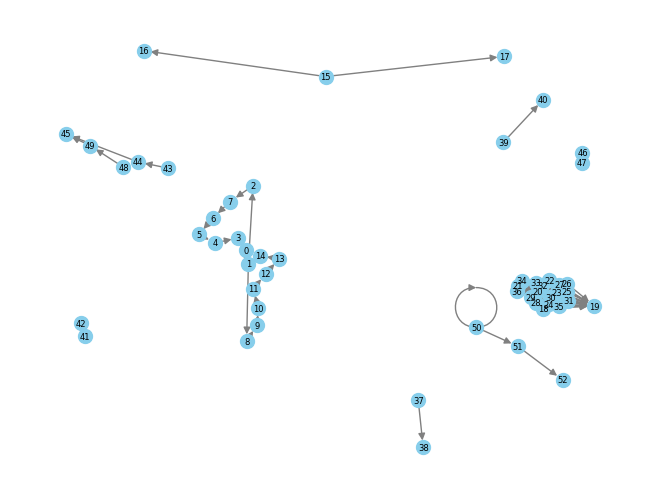

In [81]:
def collapse_multiedges(G):
    """
    Collapse parallel edges in a Networkit graph G into a single edge per node pair.
    In this example, we sum the weights of parallel edges.
    """
    # Create a simple graph with the same number of nodes and directedness.
    G_simple = nk.graph.Graph(directed=G.isDirected())
    for _ in range(G.numberOfNodes()):
        G_simple.addNode()
    # Use a dictionary to aggregate weights for each edge (u,v)
    edge_weights = {}
    for u, v, w in G.iterEdgesWeights():
        edge_weights[(u, v)] = edge_weights.get((u, v), 0) + w
    for (u, v), w in edge_weights.items():
        G_simple.addEdge(u, v, w)
    return G_simple

def plot_nk_graph(G):
    try:
        # Try converting the graph directly.
        nxG = nk.nxadapter.nk2nx(G)
    except AssertionError:
        # If an assertion error is raised due to parallel edges, collapse them.
        G_simple = collapse_multiedges(G)
        nxG = nk.nxadapter.nk2nx(G_simple)
    pos = nx.spring_layout(nxG, seed=42)  # Using a fixed seed for reproducibility.
    nx.draw(nxG, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=100, font_size=6)
    plt.show()

# Assuming G is your Networkit graph:
plot_nk_graph(G)